In [3]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import RobustScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

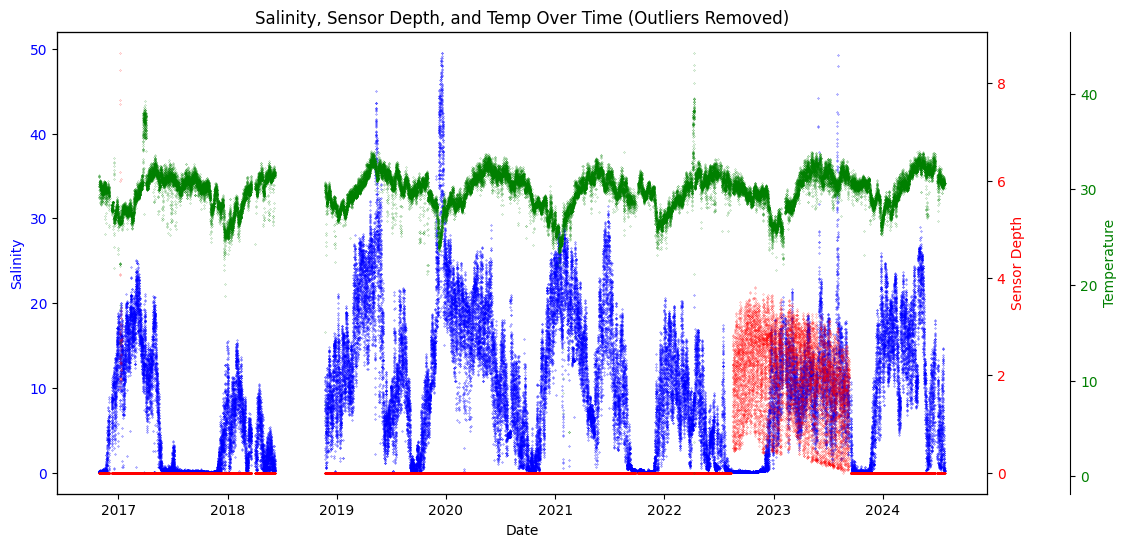

In [4]:
# Load the data
csv_file2 = '/Users/ratchanonkhongsawi/Desktop/CMKL/2nd/FALL/RND1/Data/cleaned_faifa_v2.csv'
df2 = pd.read_csv(csv_file2)

# Convert date_time to datetime format and set as the index
df2['date_time'] = pd.to_datetime(df2['date_time'], format='%Y-%m-%d %H:%M:%S')
df2.set_index('date_time', inplace=True)

# Filter for columns 'Salinity' and 'Sensor_Depth' and remove rows with NaN values
df2 = df2.loc[: , ['Salinity', 'Sensor_Depth', 'Temperature']].dropna()

# Remove outliers in Sensor_Depth (e.g., values below -10, assuming they're erroneous)
df2 = df2[(df2['Salinity'] > 0) & (df2['Salinity'] < 50)]

# Plot both columns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Salinity data
ax1.plot(df2.index, df2['Salinity'], '.', markersize=0.5, label='Salinity', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the scaled Sensor_Depth
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['Sensor_Depth'], '.', markersize=0.3, label='Sensor Depth', color='r')
ax2.set_ylabel('Sensor Depth', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Plot Temperature data on the third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset for the third axis
ax3.plot(df2.index, df2['Temperature'], '.', markersize=0.3, label='Temperature', color='g')
ax3.set_ylabel('Temperature', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Title and show plot
plt.title('Salinity, Sensor Depth, and Temp Over Time (Outliers Removed)')
plt.show()

In [5]:
df = df2.loc['2019-01-01':, ['Salinity']].dropna()

# Define column indices dictionary for df
column_indices = {name: i for i, name in enumerate(df.columns)}

# Split data into training, validation, and test sets
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Define number of features based on df1's columns
num_features = df.shape[1]

NameError: name 'df1' is not defined

In [ ]:
scaler = RobustScaler()
train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

train_df = np.log1p(train_df)
val_df = np.log1p(val_df)
test_df = np.log1p(test_df)

# Calculate the mean and standard deviation of the training data
train_mean = train_df.mean()  # Mean of each column in the training set
train_std = train_df.std()    # Standard deviation of each column in the training set

# Normalize the training set
train_df = (train_df - train_mean) / train_std  # Center data around 0 with unit variance

# Normalize the validation set using the training mean and standard deviation
val_df = (val_df - train_mean) / train_std  

# Normalize the test set using the training mean and standard deviation
test_df = (test_df - train_mean) / train_std

train_df = pd.DataFrame(train_df, columns=['Salinity'])
val_df = pd.DataFrame(val_df, columns=['Salinity'])
test_df = pd.DataFrame(test_df, columns=['Salinity'])

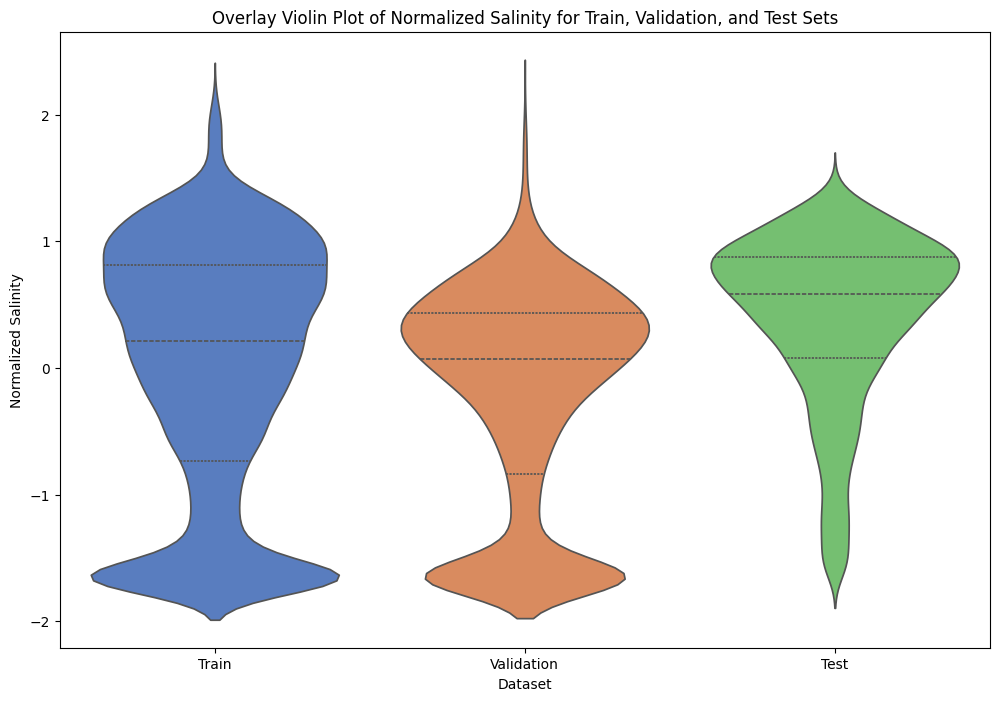

In [ ]:
# Assuming you have your data as Pandas DataFrames
af_train_df_graph = pd.DataFrame(train_df, columns=['Salinity'])
af_val_df_graph = pd.DataFrame(val_df, columns=['Salinity'])
af_test_df_graph = pd.DataFrame(test_df, columns=['Salinity'])
# train_df, val_df, and test_df should already be normalized

# Combine the data into a single DataFrame for visualization
af_train_df_graph['Dataset'] = 'Train'
af_val_df_graph['Dataset'] = 'Validation'
af_test_df_graph['Dataset'] = 'Test'

# Stack the data for plotting
combined_af_df = pd.concat([af_train_df_graph, af_val_df_graph, af_test_df_graph])

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=combined_af_df, x='Dataset', y='Salinity', hue='Dataset', inner='quartile', palette='muted', legend=False)

# Add title and labels
plt.title("Overlay Violin Plot of Normalized Salinity for Train, Validation, and Test Sets")
plt.xlabel("Dataset")
plt.ylabel("Normalized Salinity")

# Display the plot
plt.show()

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Salinity'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Salinity']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 1)
Inputs shape: (3, 24, 1)
Labels shape: (3, 1, 1)


In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Salinity', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Date')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Salinity'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Salinity']

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['Salinity'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.0158 - mean_absolute_error: 0.0799


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Salinity'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Salinity']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


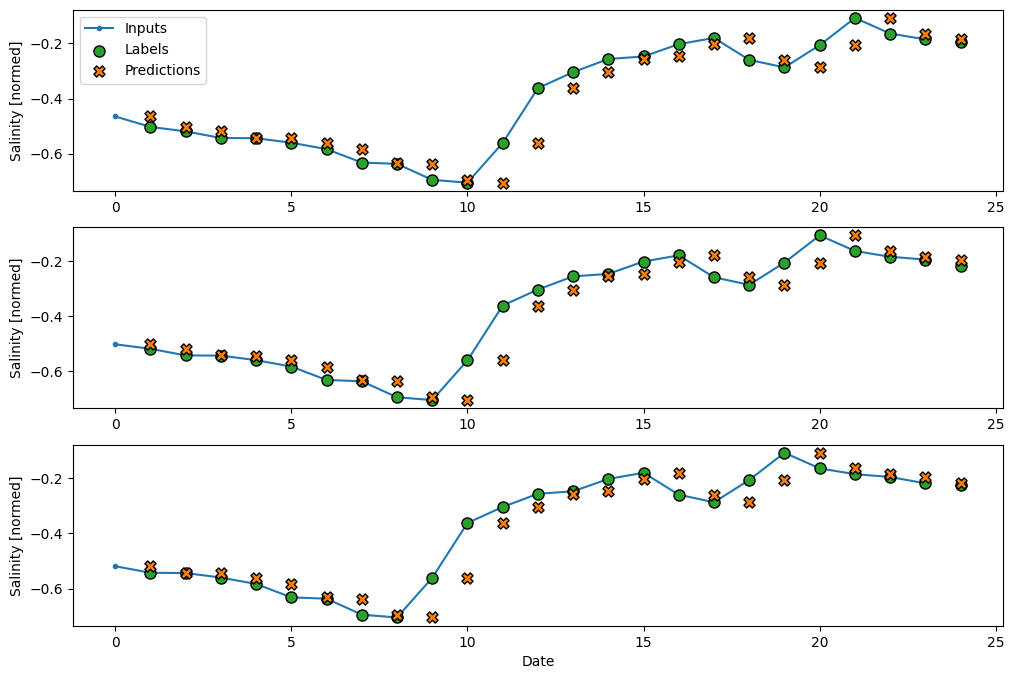

In [ ]:
wide_window.plot(baseline)

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
lstm_model16 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model16, wide_window)

IPython.display.clear_output()
val_performance['LSTM16'] = lstm_model16.evaluate(wide_window.val, return_dict=True)
performance['LSTM16'] = lstm_model16.evaluate(wide_window.test, verbose=0, return_dict=True)

288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0139 - mean_absolute_error: 0.0717


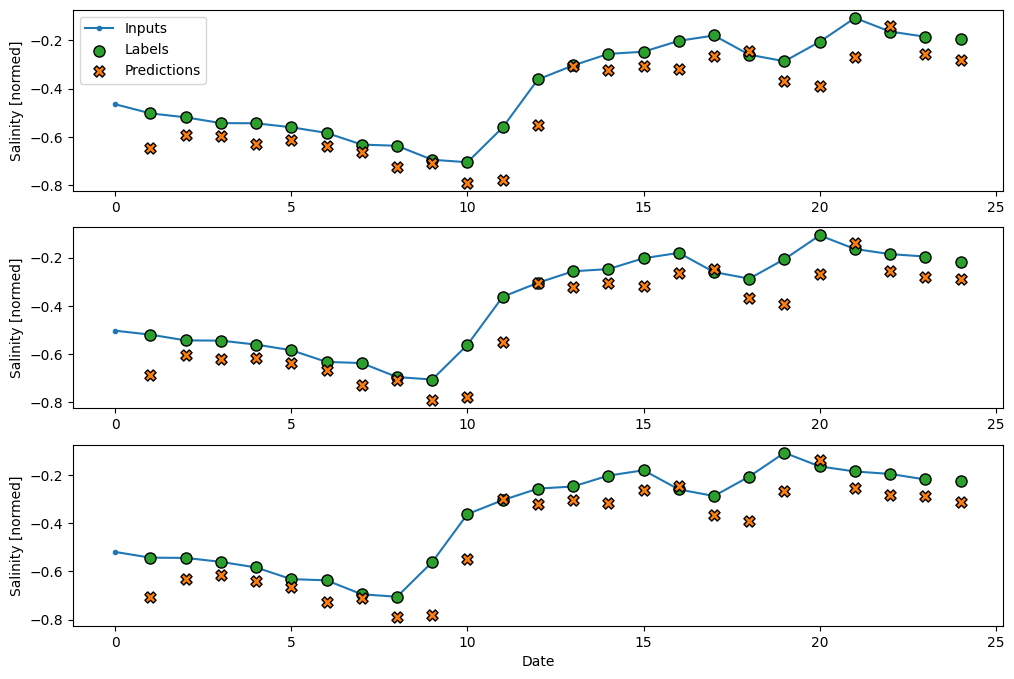

In [ ]:
wide_window.plot(lstm_model16)

In [ ]:
lstm_model32 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model32, wide_window)

IPython.display.clear_output()
val_performance['LSTM32'] = lstm_model32.evaluate(wide_window.val, return_dict=True)
performance['LSTM32'] = lstm_model32.evaluate(wide_window.test, verbose=0, return_dict=True)

288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 0.0146 - mean_absolute_error: 0.0721


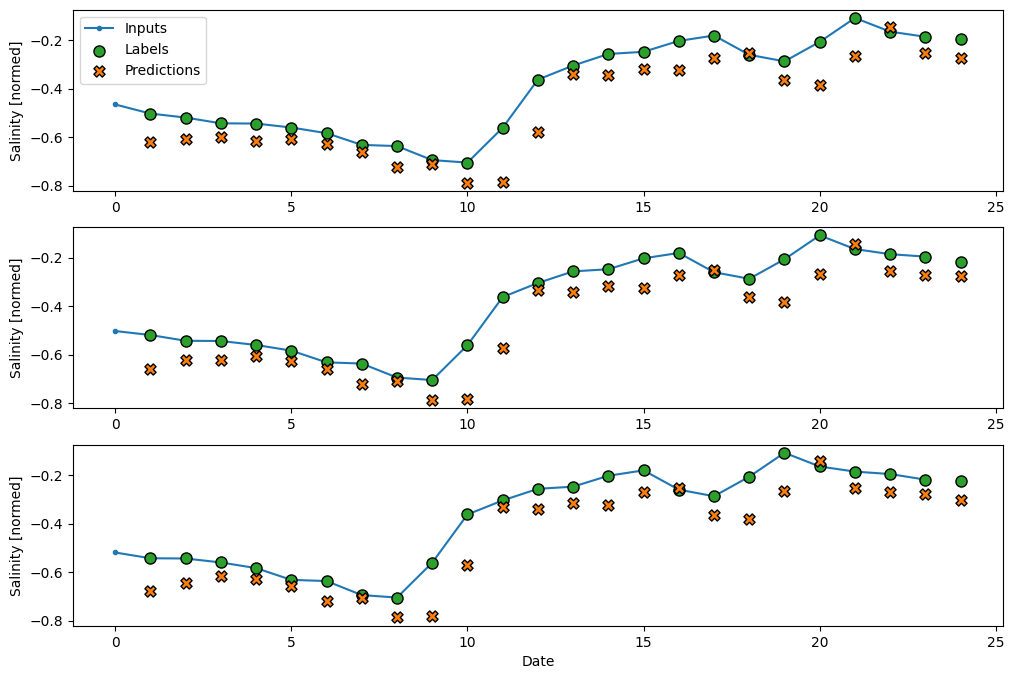

In [ ]:
wide_window.plot(lstm_model32)

In [ ]:
lstm_model64 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model64, wide_window)

IPython.display.clear_output()
val_performance['LSTM64'] = lstm_model64.evaluate(wide_window.val, return_dict=True)
performance['LSTM64'] = lstm_model64.evaluate(wide_window.test, verbose=0, return_dict=True)

288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - mean_absolute_error: 0.0750


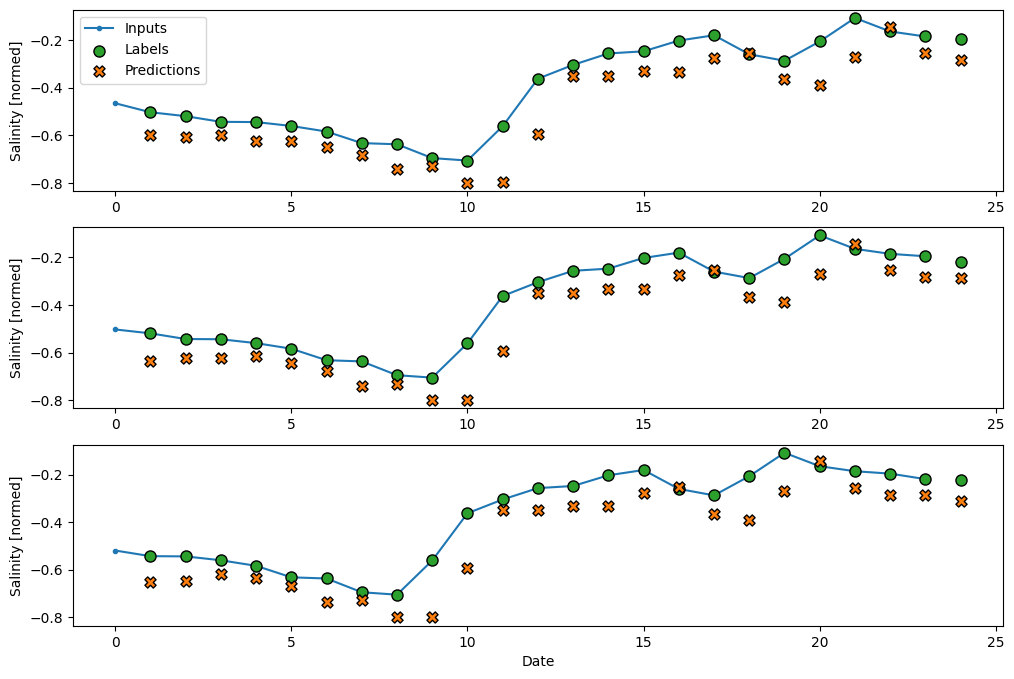

In [ ]:
wide_window.plot(lstm_model64)

In [ ]:
lstm_model128 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model128, wide_window)

IPython.display.clear_output()
val_performance['LSTM128'] = lstm_model128.evaluate(wide_window.val, return_dict=True)
performance['LSTM128'] = lstm_model128.evaluate(wide_window.test, verbose=0, return_dict=True)

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - mean_absolute_error: 0.0755


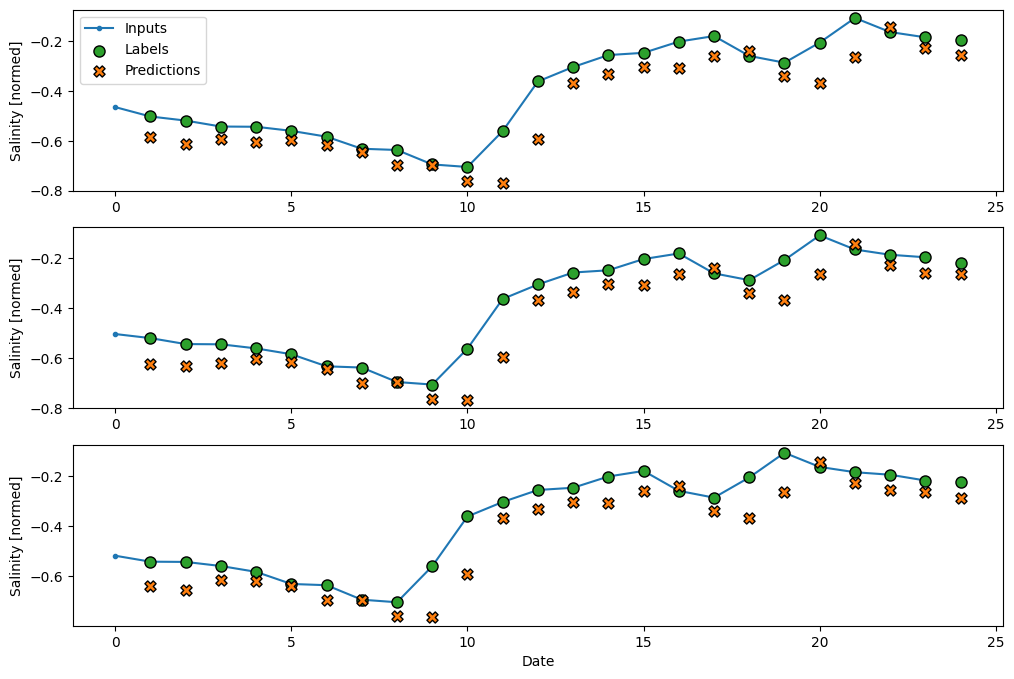

In [ ]:
wide_window.plot(lstm_model128)

In [ ]:
lstm_model256 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(256, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model256, wide_window)

IPython.display.clear_output()
val_performance['LSTM128'] = lstm_model256.evaluate(wide_window.val, return_dict=True)
performance['LSTM128'] = lstm_model256.evaluate(wide_window.test, verbose=0, return_dict=True)

288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0180 - mean_absolute_error: 0.0826


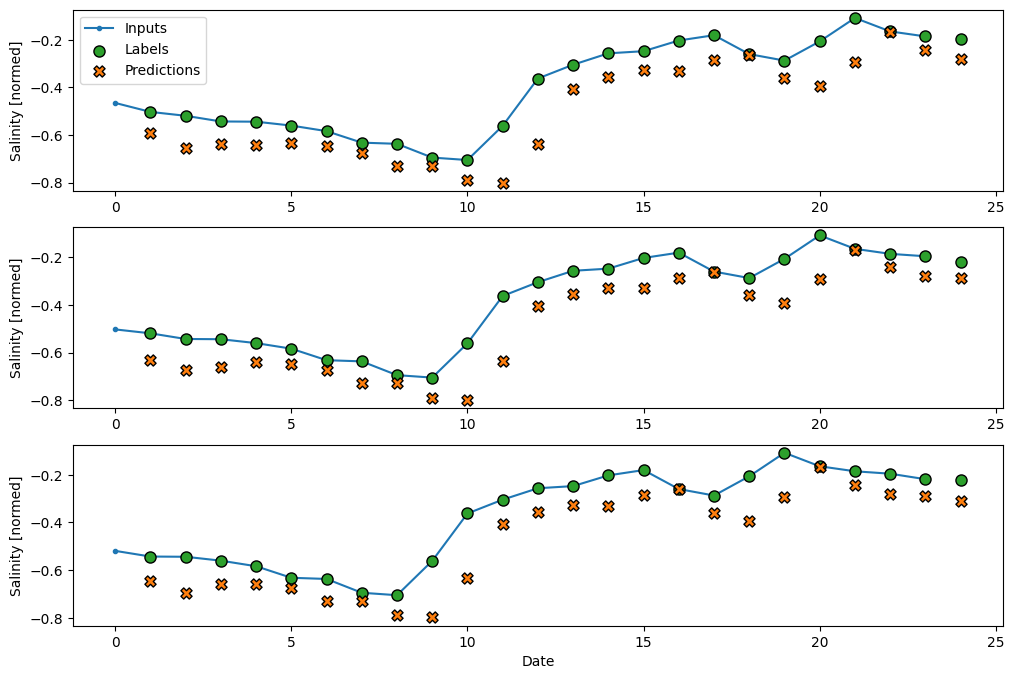

In [ ]:
wide_window.plot(lstm_model256)

In [ ]:
lstm_model512 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(521, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model512, wide_window)

IPython.display.clear_output()
val_performance['LSTM521'] = lstm_model512.evaluate(wide_window.val, return_dict=True)
performance['LSTM521'] = lstm_model512.evaluate(wide_window.test, verbose=0, return_dict=True)

288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0228 - mean_absolute_error: 0.0966


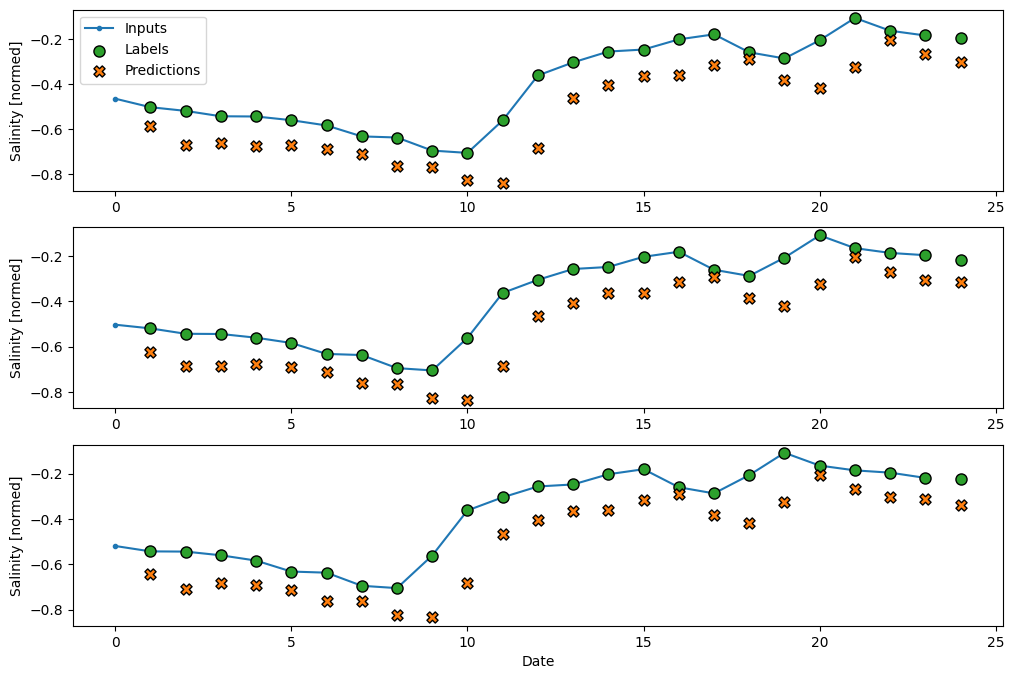

In [ ]:
wide_window.plot(lstm_model512)

In [ ]:
lstm_model1024 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(1024, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model1024, wide_window)

IPython.display.clear_output()
val_performance['LSTM1024'] = lstm_model1024.evaluate(wide_window.val, return_dict=True)
performance['LSTM1024'] = lstm_model1024.evaluate(wide_window.test, verbose=0, return_dict=True)

288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0241 - mean_absolute_error: 0.1007


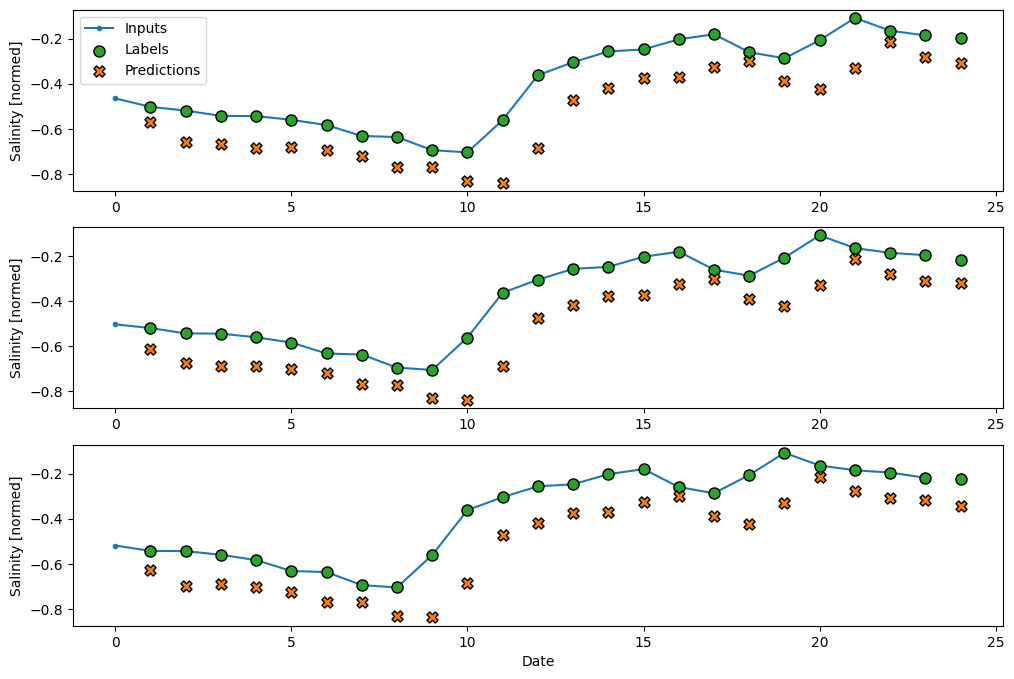

In [ ]:
wide_window.plot(lstm_model1024)

In [ ]:
cm = lstm_model16.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [ ]:
val_performance

{'Baseline': {'loss': 0.016975704580545425,
  'mean_absolute_error': 0.08244752138853073},
 'LSTM16': {'loss': 0.014827863313257694,
  'mean_absolute_error': 0.07458572089672089},
 'LSTM32': {'loss': 0.01546542439609766,
  'mean_absolute_error': 0.07506394386291504},
 'LSTM64': {'loss': 0.016187051311135292,
  'mean_absolute_error': 0.07789047062397003},
 'LSTM128': {'loss': 0.019482718780636787,
  'mean_absolute_error': 0.0867777094244957},
 'LSTM521': {'loss': 0.02547149918973446,
  'mean_absolute_error': 0.10262028872966766},
 'LSTM1024': {'loss': 0.027296457439661026,
  'mean_absolute_error': 0.10756668448448181}}

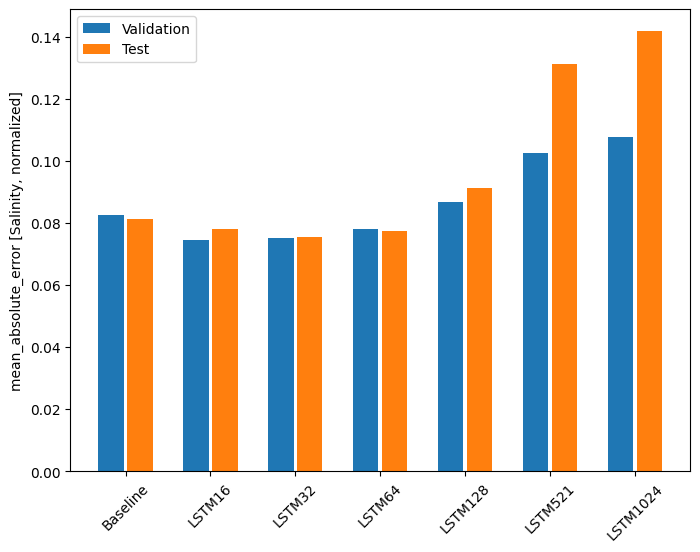

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [Salinity, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.0812
LSTM16      : 0.0782
LSTM32      : 0.0755
LSTM64      : 0.0775
LSTM128     : 0.0914
LSTM521     : 0.1311
LSTM1024    : 0.1417
